# Tree segmentation with multitemporal Sentinel 1/2 imagery

## John Brandt
## April 02, 2020

## Overview

This notebook contains the TensorFlow model training and prediction used to segment trees for [Restoration Mapper](https://restorationmapper.org). The notebook uses tensorflow 1.13.1 and additionally relies on Keras and tflearn. 

## Table of Contents

- Package loading
- Utility scripts
- Hyperparameter definitions
- Custom tensorflow layer functions
- Tensorflow graph creation
- Data loading
- Data preprocessing
- Equibatch creation
- Loss definition
- Tensorflow graph initialization
- Training
- Model validation
- Sanity Checks

## Package Loading

In [1]:
from tqdm import tqdm_notebook, tnrange
import tensorflow as tf

sess = tf.Session()
from keras import backend as K
K.set_session(sess)

from time import sleep

import keras
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.layers import ELU
from keras.losses import binary_crossentropy
from tensorflow.python.ops import array_ops
from tensorflow.python.keras.layers import Conv2D, Lambda, Dense, Multiply, Add
from tensorflow.python.keras.activations import selu
from tensorflow.initializers import glorot_normal, lecun_normal
from scipy.ndimage import median_filter
from skimage.transform import resize

import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import conv2d

import pandas as pd
import numpy as np
from random import shuffle
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import itertools
from tflearn.layers.conv import global_avg_pool
from tensorflow.contrib.framework import arg_scope
from keras.regularizers import l1
from tensorflow.layers import batch_normalization
from tensorflow.python.util import deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


## Utility scripts

In [2]:
%run ../src/zoneout.py
%run ../src/convgru.py
%run ../src/lovasz.py
%run ../src/utils.py
%run ../src/adabound.py
%run ../src/slope.py
%run ../src/dropblock.py
%run ../src/metrics_new.py

# Hyperparameter definitions

In [3]:
ZONE_OUT_PROB = 0.20
GRU_FILTERS = 32
FPA_FILTERS = 28
OUT_FILTERS = 32
AVERAGE_GRU_FILTERS = True
ACTIVATION_FUNCTION = 'relu'

INITIAL_LR = 1e-4
FINAL_LR = 2e-2
DROPBLOCK_MAXSIZE = 5
DECONV = 'bilinear'
N_CONV_BLOCKS = 1
FINAL_ALPHA = 0.7
LABEL_SMOOTHING = 0.075
BATCH_RENORM = 'norm'

L2_REG = 0.0
BN_MOMENTUM = 0.9
BATCH_SIZE = 16
MAX_DROPBLOCK = 0.85

gru_flt = 32
fpa_flt = 28
out_conv_flt = 32

IMAGE_SIZE = 16
LABEL_SIZE = 14

# Hyperparameter grid search definitions

In [4]:
# There are 3.8 million combinations of hyperparameters
params = {
    'zone_out' : [0],#range(0, 0.5, 0.1), #6
    'gru_filters': [0], #range(16, 64, 8), #6
    'fpa_filters': [0], #range(24, 48, 4), # 6
    'out_conv_filter': range(16, 64, 16), # 5
    'average_gru_filters': [True, False], # 2
    'activation_function': ['relu', 'selu', 'elu'], # 3
    'final_lr': [5e-3, 1e-2, 2e-2, 5e-2], # 4
    'dropblock_maxsize': [7, 6, 5, 4, 3], # 5
    'deconv': ['bilinear', 'convtranspose2d'], # 2
    'n_conv_blocks': [3, 2, 1], # 3
    'final_alpha': [0.8, 0.75, 0.7, 0.65, 0.6], #5
    'label_smoothing': [0., 0.025, 0.05, 0.075, 0.10, 0.125],
    'batch_renorm': ['renorm', 'norm']
}

# Custom layer definitions

### Utility blocks (Batch norm, cSSE, etc.)

In [5]:
def Batch_Normalization(x, training, scope, clipping_params):
    '''Batch renormalization layer from tensorflow.layers

         Parameters:
          x (tf.Variable): input layer
          training (tf.Variable): flag to differentiate between train/test ops
          scope (str): tensorflow scope
          clipping_params (dict): specifies clipping of 
                                  rmax, dmax, rmin for renormalization

         Returns:
          x (tf.Variable): output of batch renormalization
          
         References:
          https://github.com/tensorflow/docs/blob/r1.13/site/en/
          api_docs/python/tf/layers/batch_normalization.md
    '''
    return batch_normalization(inputs=x, 
                               momentum = BN_MOMENTUM, 
                               training=training,
                               renorm = True,
                               reuse=None,
                               renorm_clipping = clipping_params,
                               name = scope)


def calc_renorm_params(epoch, n_samples, batch_size, k = 0):
    '''Calculates the clipping parameters for renormalization
       based on the learning schedule outlined in the original paper
       where rmax is initialized to 1, dmax to 0, rmin to 0,
       (effectively batch normalization), and then rmax and dmax
       are gradually reaxed to 3 and 5 over 40k and 25k steps,
       respectively. In this case, 40k has been reduced to 30k, and 25k
       has been reduced to 20k.

         Parameters:
          epoch (int): number of current training epoch
                       if testing, epoch number of model used
          n_samples (int): total number of training samples
          batch_size (int): training batch size 

         Returns:
          rmax (float)
          dmax (float)
          rmin (float)
    '''
    step = epoch * (n_samples // batch_size)
    step += k
    if step < 2500:
        rmax = 1.
        dmax = 0.
        rmin = 0.
    if step >= 2500:
        rmax = np.min([1 + 2*((step-2500)/25000), 3])
        dmax = np.min([1 + 5*((step-2500)/15000), 5])
        rmin = 0.
    return rmax, dmax, rmin

def cse_block(prevlayer, prefix):
    '''Channel excitation and spatial squeeze layer. 
       Calculates the mean of the spatial dimensions and then learns
       two dense layers, one with relu, and one with sigmoid, to rerank the
       input channels
       
         Parameters:
          prevlayer (tf.Variable): input layer
          prefix (str): prefix for tensorflow scope

         Returns:
          x (tf.Variable): output of the cse_block
    '''
    mean = Lambda(lambda xin: K.mean(xin, axis=[1, 2]))(prevlayer)
    lin1 = Dense(K.int_shape(prevlayer)[3] // 2, name=prefix + 'cse_lin1', activation='relu')(mean)
    lin2 = Dense(K.int_shape(prevlayer)[3], name=prefix + 'cse_lin2', activation='sigmoid')(lin1)
    x = Multiply()([prevlayer, lin2])
    return x


def sse_block(prevlayer, prefix):
    '''Spatial excitation and channel squeeze layer.
       Calculates a 1x1 convolution with sigmoid activation to create a 
       spatial map that is multiplied by the input layer

         Parameters:
          prevlayer (tf.Variable): input layer
          prefix (str): prefix for tensorflow scope

         Returns:
          x (tf.Variable): output of the sse_block
    '''
    conv = Conv2D(1, (1, 1), padding="same", kernel_initializer="glorot_uniform",
                  activation='sigmoid', strides=(1, 1),
                  name=prefix + "_conv")(prevlayer)
    conv = Multiply(name=prefix + "_mul")([prevlayer, conv])
    return conv


def csse_block(x, prefix):
    '''Implementation of Concurrent Spatial and Channel 
       ‘Squeeze & Excitation’ in Fully Convolutional Networks
    
        Parameters:
          prevlayer (tf.Variable): input layer
          prefix (str): prefix for tensorflow scope

         Returns:
          x (tf.Variable): added output of cse and sse block
          
         References:
          https://arxiv.org/abs/1803.02579
    '''
    cse = cse_block(x, prefix)
    sse = sse_block(x, prefix)
    x = Add(name=prefix + "_csse_mul")([cse, sse])

    return x

class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

### Conv GRU Block

In [6]:
def gru_block(inp, length, size, flt, scope, train, normalize = True):
    '''Bidirectional convolutional GRU block with 
       zoneout and CSSE blocks in each time step

         Parameters:
          inp (tf.Variable): (B, T, H, W, C) layer
          length (tf.Variable): (B, T) layer denoting number of
                                steps per sample
          size (int): kernel size of convolution
          flt (int): number of convolution filters
          scope (str): tensorflow variable scope
          train (tf.Bool): flag to differentiate between train/test ops
          normalize (bool): whether to compute layer normalization

         Returns:
          gru (tf.Variable): (B, H, W, flt*2) bi-gru output
          steps (tf.Variable): (B, T, H, W, flt*2) output of each step
    '''
    with tf.variable_scope(scope):
        print("GRU input shape {}, zoneout: {}".format(inp.shape, ZONE_OUT_PROB))
        cell_fw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [3, 3], padding = 'VALID', normalize = normalize, fpa = True)
        cell_bw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [3, 3], padding = 'VALID', normalize = normalize, fpa = True)
        cell_fw = ZoneoutWrapper(
           cell_fw, zoneout_drop_prob = ZONE_OUT_PROB, is_training = train)
        cell_bw = ZoneoutWrapper(
            cell_bw, zoneout_drop_prob = ZONE_OUT_PROB, is_training = train)
        steps, out = convGRU(inp, cell_fw, cell_bw, length)
        gru = tf.concat(out, axis = -1)
        steps = tf.concat(steps, axis = -1)
        print("Down block output shape {}".format(gru.shape))
    return gru, steps

### Conv blocks

In [8]:
def conv_selu(inp, is_training, kernel_size, scope,
                filter_count = 16, pad = True, padding = 'valid', dilated = False,
                activation = True):
    '''Convolutional 2D layer with SELU activation and Lecun normal initialization
       with no batch norm. Only used if params['activation'] = 'selu'

         Parameters:
          inp (tf.Variable): (B, H, W, C) input layer
          is_training (str): flag to differentiate between train/test ops
          kernel_size (int): kernel size of convolution
          scope (str): tensorflow variable scope
          filter_count (int): number of convolution filters
          pad (bool): whether or not to reflect pad input
          padding (str): one of ['valid', 'same']
          dilated (bool): whether to perform atruous convolution
          activation (bool): whether to activate output

         Returns:
          conv (tf.Variable): output of Conv2D -> SELU
          
         References:
          https://arxiv.org/abs/1706.02515
    '''
    if activation:
        act = selu
    else:
        act = None
    if not dilated:
        padded = ReflectionPadding2D((1, 1,))(inp)
        conv = Conv2D(filters = filter_count, kernel_size = (kernel_size, kernel_size), activation = act,
                        padding = padding, kernel_initializer = lecun_normal())(padded)
    if not dilated and not pad:
        conv = Conv2D(filters = filter_count, kernel_size = (kernel_size, kernel_size), activation = act,
                        padding = padding, kernel_initializer = lecun_normal())(inp)
    if dilated:
        padded = ReflectionPadding2D((2, 2,))(inp)
        conv = Conv2D(filters = filter_count, kernel_size = (3, 3), activation = act, dilation_rate = (2, 2),
                        padding = padding, kernel_initializer = lecun_normal())(padded)
    return conv

def conv_bn_relu(inp, 
                 is_training, 
                 kernel_size,
                 scope,
                 filters, 
                 clipping_params,
                 keep_rate,
                 activation = True,
                 use_bias = False,
                 batch_norm = True):
    
    '''2D convolution, batch renorm, relu block, 3x3 drop block. 
       Use_bias must be set to False for batch normalization to work. 
       He normal initialization is used with batch normalization.
       RELU is better applied after the batch norm.
       DropBlock performs best when applied last, according to original paper.

         Parameters:
          inp (tf.Variable): input layer
          is_training (str): flag to differentiate between train/test ops
          kernel_size (int): size of convolution
          scope (str): tensorflow variable scope
          filters (int): number of filters for convolution
          clipping_params (dict): specifies clipping of 
                                  rmax, dmax, rmin for renormalization
          activation (bool): whether to apply RELU
          use_bias (str): whether to use bias. Should always be false

         Returns:
          bn (tf.Variable): output of Conv2D -> Batch Norm -> RELU
        
         References:
          http://papers.nips.cc/paper/8271-dropblock-a-regularization-
              method-for-convolutional-networks.pdf
          https://arxiv.org/abs/1702.03275
          
    '''
    
    conv = Conv2D(filters = filters, kernel_size = (kernel_size, kernel_size), 
                  activation = None, padding = 'valid', use_bias = use_bias,
                  kernel_initializer = tf.keras.initializers.he_normal())(inp)
    if batch_norm:
        conv = Batch_Normalization(conv, is_training, scope, clipping_params)
    if activation:
        conv = tf.nn.relu(conv)
    drop_block = DropBlock2D(keep_prob=keep_rate, block_size=3)
    conv = drop_block(conv, is_training)

    return conv


def create_deconv_init(filter_size, num_channels):
    '''Initializes a kernel weight matrix with a bilinear deconvolution
    
         Parameters:
          filter_size (int): kernel size of convolution
          num_channels (int): number of filters for convolution

         Returns:
          bilinear_init (tf.Variable): [filter_size, filter_size, num_channels] kernel
    '''
    bilinear_kernel = np.zeros([filter_size, filter_size], dtype=np.float32)
    scale_factor = (filter_size + 1) // 2
    if filter_size % 2 == 1:
        center = scale_factor - 1
    else:
        center = scale_factor - 0.5
    for x in range(filter_size):
        for y in range(filter_size):
            bilinear_kernel[x,y] = (1 - abs(x - center) / scale_factor) * \
                                   (1 - abs(y - center) / scale_factor)
    weights = np.zeros((filter_size, filter_size, num_channels, num_channels))
    for i in range(num_channels):
        weights[:, :, i, i] = bilinear_kernel

    #assign numpy array to constant_initalizer and pass to get_variable
    bilinear_init = tf.constant_initializer(value=weights, dtype=tf.float32)
    return bilinear_init

def get_deconv2d(inp, filter_count, num_channels, scope, is_training, clipping_params):
    '''Creates a deconvolution layer with Conv2DTranspose. Following recent
       recommendations to use 4 kernel, 2 stride to avoid artifacts. 
       Initialize kernel with bilinear upsampling.

         Parameters:
          inp (tf.Variable): input tensorflow layer (B, X, Y, C) shape
          filter_count (int): number of filters for convolution
          num_channels (int): number of output channels
          scope (str): tensorflow variable scope
          is_training (str): flag to differentiate between train/test ops
          clipping_params (dict): specifies clipping of 
                                  rmax, dmax, rmin for renormalization

         Returns:
          x (tf.Variable): layer with (B, x * 2, y * 2, C) shape
          
         References:
          https://distill.pub/2016/deconv-checkerboard/
    '''
    bilinear_init = create_deconv_init(4, filter_count)
    x = tf.keras.layers.Conv2DTranspose(filters = filter_count, kernel_size = (4, 4),
                                        strides=(2, 2), padding='same', 
                                        use_bias = False,
                                        kernel_initializer = bilinear_init)(inp)
    #x = ELU()(x)
    #x = tf.nn.relu(x)
    x = Batch_Normalization(x, training=is_training, scope = scope + "bn", clipping_params = clipping_params)
    return x
    
def fpa(inp, is_training, filter_count, clipping_params, 
        keep_rate, upsample = "upconv"):
    '''Feature pyramid attention layer block, that allows for cross-scale combination
       of different size features without making blurry feature maps.

         Parameters:
          inp (tf.Variable): input tensorflow layer
          is_training (str): flag to differentiate between train/test ops
          filter_count (int): number of filters for convolution
          clipping_params (dict): specifies clipping of 
                                  rmax, dmax, rmin for renormalization

         Returns:
          concat_1 (tf.Variable): output of FPA
          
         References:
          https://arxiv.org/abs/1805.10180
    '''
    one = conv_bn_relu(inp = inp, is_training = is_training, 
                       kernel_size = 1, scope =  'forward1',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = False,
                       use_bias = False, batch_norm = True)
    
    five = conv_bn_relu(inp = inp, is_training = is_training, 
                       kernel_size = 5, scope =  'down1',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = True,
                       use_bias = False, batch_norm = True)
    
    five_f = conv_bn_relu(inp = five, is_training = is_training, 
                       kernel_size = 5, scope =  'down1_f',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = False,
                       use_bias = False, batch_norm = True)
    
    three = conv_bn_relu(inp = five, is_training = is_training, 
                       kernel_size = 3, scope =  'down2',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = True,
                       use_bias = False, batch_norm = True)
    
    three_f = conv_bn_relu(inp = three, is_training = is_training, 
                       kernel_size = 3, scope =  'down2_f',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = False,
                       use_bias = False, batch_norm = True)
        
    
    if upsample == 'upconv' or 'bilinear':
        three_up = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'nearest')(three_f)
        if upsample == 'upconv':
            three_up = ReflectionPadding2D((1, 1,))(three_up)
            three_up = conv_bn_relu(inp = three_up, is_training = is_training, 
                       kernel_size = 3, scope =  'upconv1',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = False,
                       use_bias = False, batch_norm = True)
    
    if upsample == 'deconv':
        three_up = get_deconv2d(three_f, filter_count, filter_count, 'three_up', is_training, 
                            clipping_params = clipping_params)
    three_up = tf.nn.relu(three_up)
    
    if upsample == 'upconv' or "bilinear":
        five_up = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'nearest')(five_f)
        if upsample == 'upconv':
            five_up = ReflectionPadding2D((1, 1,))(five_up)
            five_up = conv_bn_relu(inp = five_up, is_training = is_training, 
                       kernel_size = 3, scope =  'upconv2',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = False,
                       use_bias = False, batch_norm = True)
    
    if upsample == 'deconv':
        five_up = get_deconv2d(five_f, filter_count, filter_count, 'five_up', is_training, 
                           clipping_params = clipping_params)
    five_up = tf.nn.relu(five_up)
    
    print("One: {}".format(one.shape))
    print("Five: {}".format(five.shape))
    print("Five_F: {}".format(five_f.shape))
    print("Three: {}".format(three.shape))
    print("Three_f: {}".format(three_f.shape))
    print("Three_up: {}".format(three_up.shape))
    print("Five_up: {}".format(five_up.shape))
    
    # top block
    #pooled = tf.keras.layers.GlobalAveragePooling2D()(inp)
    #one_top = conv_bn_elu(tf.reshape(pooled, (-1, 1, 1, pooled.shape[-1])),
    #                      is_training, 1, 'top1', filter_count, pad = False)
    #four_top = tf.keras.layers.UpSampling2D((16, 16))(one_top)
    #rint("Sixteen top: {}".format(four_top.shape))
    
    
    concat_1 = tf.nn.relu(tf.multiply(one, tf.nn.relu(tf.add(three_up, five_up))))
    #concat_2 = tf.add(concat_1, four_top)
    print("Feature pyramid attention shape {}".format(concat_1.shape))
    return concat_1

# Model definition

## Placeholders

In [9]:
n_bands = 16
reg = keras.regularizers.l2(L2_REG) # for GRU
inp = tf.placeholder(tf.float32, shape=(None, 24, IMAGE_SIZE, IMAGE_SIZE, n_bands))
length = tf.placeholder(tf.int32, shape = (None, 1))
labels = tf.placeholder(tf.float32, shape=(None, 14, 14))#, 1))
keep_rate = tf.placeholder_with_default(1.0, ()) # For DropBlock
length2 = tf.reshape(length, (-1,)) # Remove
is_training = tf.placeholder_with_default(False, (), 'is_training') # For BN, DropBlock
alpha = tf.placeholder(tf.float32, shape = ()) # For loss scheduling
ft_lr = tf.placeholder_with_default(0.001, shape = ()) # For loss scheduling


In [10]:
rmax = tf.placeholder(tf.float32, shape = ())
rmin = tf.placeholder(tf.float32, shape = ())
dmax = tf.placeholder(tf.float32, shape = ())

clipping_params = {
    'rmax': rmax,
    'rmin': rmin,
    'dmax': dmax
}

## Layers

In [11]:
# Split out slope for temporal modeling
inp_first_half = inp[:, :, :, :, :10]
inp_second_half = inp[:, :, :, :, 11:]
no_dem = tf.concat([inp_first_half, inp_second_half], axis = -1)
dem = tf.reshape(tf.reduce_mean(inp[:, :, :, :, 10], axis = 1), (-1, 16, 16, 1))
gru_out, steps = gru_block(inp = no_dem, length = length2, 
                            size = [16, 16], 
                            flt = gru_flt, 
                            scope = 'down_16', 
                            train = is_training)

#steps = tf.reduce_mean(steps, axis = 1)

gru_out = tf.concat([gru_out, dem], axis = -1)

# CSSE, Drop
csse1 = csse_block(gru_out, 'csse1')

# FPA, CSSE, 4x4 Drop block
fpa1 = fpa(csse1, is_training, fpa_flt, clipping_params, keep_rate)
csse2 = csse_block(fpa1, 'csse2')

# Skip connect
x = tf.concat([csse2, csse1], axis = -1)

x = conv_bn_relu(inp = x, 
                 is_training = is_training,
                 kernel_size = 3,
                 scope = "outconv2", 
                 filters = out_conv_flt, 
                 clipping_params = clipping_params,
                 activation = True,
                 keep_rate = keep_rate, 
                 use_bias = False,
                 batch_norm = True)

print("Initializing last sigmoid bias with -2.94 constant")
init = tf.constant_initializer([-np.log(0.7/0.3)]) # For focal loss
fm = Conv2D(filters = 1,
            kernel_size = (1, 1), 
            padding = 'valid',
            activation = 'sigmoid',
            bias_initializer = init,
           )(x) # For focal loss

GRU input shape (?, 24, 16, 16, 15), zoneout: 0.2
(3, 3, 47, 64)
(1, 1, 64, 1)
(?, 16, 16, 64)
(3, 3, 47, 64)
(1, 1, 64, 1)
(?, 16, 16, 64)
Down block output shape (?, 16, 16, 64)
One: (?, 16, 16, 28)
Five: (?, 12, 12, 28)
Five_F: (?, 8, 8, 28)
Three: (?, 10, 10, 28)
Three_f: (?, 8, 8, 28)
Three_up: (?, 16, 16, 28)
Five_up: (?, 16, 16, 28)
Feature pyramid attention shape (?, 16, 16, 28)
Initializing last sigmoid bias with -2.94 constant


In [12]:
total_parameters = 0
for variable in tf.trainable_variables():
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    total_parameters += variable_parameters
print("This model has {} parameters".format(total_parameters))

This model has 209387 parameters


# Data loading

*  Load in CSV data from Collect Earth
*  Reconstruct the X, Y grid for the Y data per sample
*  Calculate NDVI, EVI, SAVI, BI, MSAVI2, and SI
*  Stack X, Y, length data
*  Apply median filter to DEM

In [13]:
train_x = np.load("../tile_data/processed/data_x_l2a_processed.npy")
train_y = np.load("../tile_data/processed/data_y_l2a_processed.npy")
train_l = np.load("../tile_data/processed/length_l2a_processed.npy")

train_x = np.delete(train_x, 14, -1) 

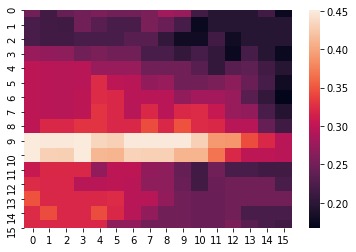

In [14]:
sns.heatmap(train_x[65, 0, :, :, 10])

In [15]:
holdout_for_vis = np.copy(train_x[65, 0, :, :, 10])
for sample in tnrange(0, len(train_x)):
    filtered = median_filter(train_x[sample, 0, :, :, 10], size = 5)
    filtered = np.reshape(filtered, (8, 2, 8, 2))
    filtered = np.mean(filtered, axis = (1, 3))
    filtered = resize(filtered, (16, 16), 0)
    train_x[sample, :, :, :, 10] = np.stack([filtered] * 24)
    
print(train_x.shape)


(4368, 24, 16, 16, 16)


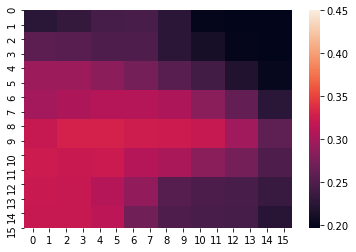

In [16]:
sns.heatmap(train_x[65, 0, :, :, 10], vmax = 0.45)

# Data preprocessing

*  Identify and remove samples with time steps / channels that have a 0. or 1. value, which indicates missing data
*  Identify and remove samples with time steps / channels with no variation, which indicates missing data
*  Identify and remove samples with values above or below the allowable values for the band
*  Identify and remove samples with null data, or samples with extreme band 0 data (which squash all the "clean" samples)
*  Smooth per-pixel temporal data with Whittaker smoother, d = 2, lambda = 0.5 to reduce sample noise

In [17]:
below_1 = [i for i, val in enumerate(train_x[:, :, :, :, :-2]) if np.min(val) < -1.5]
above_1 = [i for i, val in enumerate(train_x[:, :, :, :, :-2]) if np.max(val) > 1.5]
min_vals = [np.min(val) for i, val in enumerate(train_x[:, :, :, :, :-2]) if np.min(val) < -1.5]
max_vals = [np.max(val) for i, val in enumerate(train_x[:, :, :, :, :-2]) if np.max(val) > 1.5]
nans = [i for i, val in enumerate(train_x) if np.sum(np.isnan(val)) > 0]
oob_vals = [i for i, val in enumerate(train_x) if np.max(val[:, :, :, 0]) > 0.7]

outliers = below_1 + above_1 + nans + oob_vals
outliers = list(set(outliers))
print("Removing {} outlying training data points".format(len(outliers)))
print("\n")

train_x = train_x[[x for x in range(0, len(train_x)) if x not in outliers]]
train_y = train_y[[x for x in range(0, len(train_y)) if x not in outliers]]
train_l = train_l[[x for x in range(0, len(train_l)) if x not in outliers]]

Removing 42 outlying training data points




## Temporal Smoothing

In [18]:
# March 2 model
min_all = [0.020395646858960392,
 0.03833778686821461,
 0.022913980782032013,
 0.08838867269456387,
 0.05731564749032259,
 0.0796274145692587,
 0.08639285631477833,
 0.08918419919908048,
 0.07416137464344502,
 0.04398707151412964,
 0.0,
 0.008659180235117674,
 -0.0134716229327023,
 0.006902076792903247,
 0.006362500241957605,
 4.999999873689376e-05]

max_all = [0.18219037026166907,
 0.27367106080055237,
 0.3996005910634992,
 0.4859166720509528,
 0.4492199122905731,
 0.46700127094984045,
 0.49433933556079857,
 0.5116616946458816,
 0.6353135156631469,
 0.5636022371053693,
 0.3590170443058014,
 0.693415229320526,
 0.3948741647601127,
 0.6290205121040344,
 0.8152220940589849,
 0.14367499947547913]

min_all = []
max_all = []
#
for band in range(0, train_x.shape[-1]):
    mins = np.percentile(train_x[:, :, :, :, band], 1)
    maxs = np.percentile(train_x[:, :, :, :, band], 99)
    #mins = min_all[band]
    #maxs = max_all[band]
    #print(mins1 - mins, maxs1 - maxs)
    train_x[:, :, :, :, band] = np.clip(train_x[:, :, :, :, band], mins, maxs)
    midrange = (maxs + mins) / 2
    rng = maxs - mins
    standardized = (train_x[:, :, :, :, band] - midrange) / (rng / 2)
    train_x[:, :, :, :, band] = standardized
    
    min_all.append(mins)
    max_all.append(maxs)
    
print("The data has been scaled to [{}, {}]".format(np.min(train_x), np.max(train_x)))

The data has been scaled to [-1.0000001192092896, 1.0000001192092896]


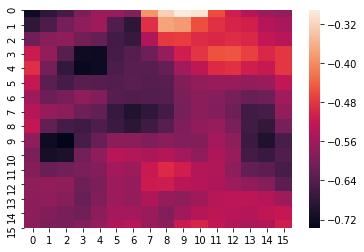

In [19]:
sns.heatmap(train_x[12, 5, :, :, 6])

# Augment training data

Horizontal and vertical flips for 4x augmentation.

**To do**
*  Random guassian noise
*  Brightness, contrast
*  Region swaps (randomply position positive samples at different locations)

## Load and process test data

In [ ]:
test_x = np.load("../tile_data/processed/test_x_l2a_processed.npy")
test_y = np.load("../tile_data/processed/test_y_l2a_processed.npy")
test_lengths = np.load("../tile_data/processed/test_length_l2a_processed.npy")

test_x = np.delete(test_x, 14, -1)

below_1 = [i for i, val in enumerate(test_x[:, :, :, :, :-2]) if np.min(val) < -1.5]
above_1 = [i for i, val in enumerate(test_x[:, :, :, :, :-2]) if np.max(val) > 1.5]
min_vals = [np.min(val) for i, val in enumerate(test_x[:, :, :, :, :-2]) if np.min(val) < -1.5]
max_vals = [np.max(val) for i, val in enumerate(test_x[:, :, :, :, :-2]) if np.max(val) > 1.5]
nans = [i for i, val in enumerate(test_x) if np.sum(np.isnan(val)) > 0]
outliers = below_1 + above_1 + nans
outliers = list(set(outliers))
print("There are {} outliers".format(len(outliers)))
print("\n")
print(min_vals, max_vals)
        
test_x = test_x[[x for x in range(0, len(test_x)) if x not in outliers]]
test_y = test_y[[x for x in range(0, len(test_y)) if x not in outliers]]
test_lengths = test_lengths[[x for x in range(0, len(test_lengths)) if x not in outliers]]

for sample in tnrange(0, len(test_x)):
    filtered = median_filter(test_x[sample, 0, :, :, 10], size = 5)
    filtered = np.reshape(filtered, (8, 2, 8, 2))
    filtered = np.mean(filtered, axis = (1, 3))
    filtered = resize(filtered, (16, 16), 0)
    test_x[sample, :, :, :, 10] = np.stack([filtered] * 24)
    
for band in range(0, test_x.shape[-1]):
    mins = min_all[band]
    maxs = max_all[band]
    test_x[:, :, :, :, band] = np.clip(test_x[:, :, :, :, band], mins, maxs)
    midrange = (maxs + mins) / 2
    rng = maxs - mins
    standardized = (test_x[:, :, :, :, band] - midrange) / (rng / 2)
    test_x[:, :, :, :, band] = standardized
    
    
print("The data has been scaled to [{}, {}]".format(np.min(test_x), np.max(test_x)))
print(test_x.shape)

In [21]:
print("Train and test characteristics:")
print("Train mean Y {}".format(np.mean([np.sum(x) for x in test_y])))
print("Test STD Y {}".format(np.std([np.sum(x) for x in test_y])))
#print("Train number with zero trees {}".format(0.2*len([x for x in data_y[train_ids] if np.sum(x) == 0])))
#print("Test number with zero trees {}".format(0.8*len([x for x in data_y[test_ids] if np.sum(x) == 0])))
print("Train mean NDVI")
print("Test mean NDVI")
#print("There are {} train and {} test samples".format(len(train_ids), len(test_ids)))
#print("There is {} overlap between train and test".format(len([x for x in train_ids if x in test_ids])))

Train and test characteristics:
Train mean Y 66.31386861313868
Test STD Y 73.02185972325405
Train mean NDVI
Test mean NDVI


# Equibatch creation

The modelling approach uses equibatch sampling to ensure that there is a near constant standard deviation of the percent tree cover in the output labels for each batch. This helps ensure that the model performs equally well across gradients of tree cover, by mitigating the random possibility that many batches in a row near the end of sampling may be randomly biased towards a tree cover range.

In [22]:
sums = np.sum(train_y, axis = (1, 2))
percents = [np.percentile(sums, x) for x in range(3*10, 100, 10)]
print(percents)
print("There are {} zeros".format(len(np.argwhere(sums == 0))))

[6.0, 14.0, 23.0, 36.0, 61.0, 115.0, 183.5]
There are 801 zeros


In [23]:
train_ids = [x for x in range(0, len(train_y))]

def multiplot(matrices):
    '''Plot multiple heatmaps with subplots
    
         Parameters:
          matrices (list of arrays):

         Returns:
          None
    '''
    fig, axs = plt.subplots(ncols=4)
    fig.set_size_inches(20, 4)
    for i, matrix in enumerate(matrices):
        sns.heatmap(data = matrix, ax = axs[i], vmin = 0, vmax = 0.9)
        axs[i].set_xlabel("")
        axs[i].set_ylabel("")
        axs[i].set_yticks([])
        axs[i].set_xticks([])

def equibatch(train_ids, p = percents, lovasz = False):
    '''Docstring
    
         Parameters:
          train_ids (list):
          p (list):
          lovasz (bool):

         Returns:
          equibatches (list):
    '''
    percents = [7.0, 13.0, 21.0, 33.0, 50.0, 80.0, 130.0] # overall
    #percents = [10., 20., 35., 50., 70., 110., 150.]
    #percents = [20.0, 40.0, 65.0, 85.0, 120.0, 155.0, 180.0] # LAC
    np.random.shuffle(train_ids)
    ix = train_ids
    percs = [np.sum(x) for x in train_y[ix]]
    ids0 = [x for x, z in zip(ix, percs) if z <= 2]
    ids30 = [x for x, z in zip(ix, percs) if 2 < z < percents[0]]
    ids40 = [x for x, z in zip(ix, percs) if percents[0] < z < percents[1]]
    ids50 = [x for x, z in zip(ix, percs) if percents[1] < z < percents[2]]
    ids60 = [x for x, z in zip(ix, percs) if percents[2] < z < percents[3]]
    ids70 = [x for x, z in zip(ix, percs) if percents[3] < z < percents[4]]
    ids80 = [x for x, z in zip(ix, percs) if percents[4] < z < percents[5]]
    ids90 = [x for x, z in zip(ix, percs) if percents[5] < z < percents[6]]
    ids100 = [x for x, z in zip(ix, percs) if percents[6] < z]
    

    new_batches = []
    maxes = [len(ids0), len(ids30), len(ids40), len(ids50), len(ids60), len(ids70),
             len(ids80), len(ids90), len(ids100)]
    print(maxes)
    cur_ids = [0] * len(maxes)
    iter_len = len(train_ids)//(len(maxes))
    for i in range(0, iter_len):
        for i, val in enumerate(cur_ids):
            if val > maxes[i] - 1:
                cur_ids[i] = 0
        if cur_ids[0] >= (maxes[0] - 2):
            cur_ids[0] = 0
        to_append = [ids0[cur_ids[0]],
                    ids30[cur_ids[1]], ids40[cur_ids[2]],
                    ids50[cur_ids[3]],
                    ids60[cur_ids[4]], ids70[cur_ids[5]], ids80[cur_ids[6]],
                    ids90[cur_ids[7]], ids100[cur_ids[8]]]
        
        np.random.shuffle(to_append)
        new_batches.append(to_append)
        cur_ids = [x + 1 for x in cur_ids]
        #cur_ids[0] += 1
        
    new_batches = [item for sublist in new_batches for item in sublist]
    return new_batches

batch = equibatch(train_ids)

[979, 323, 301, 340, 382, 356, 341, 295, 786]


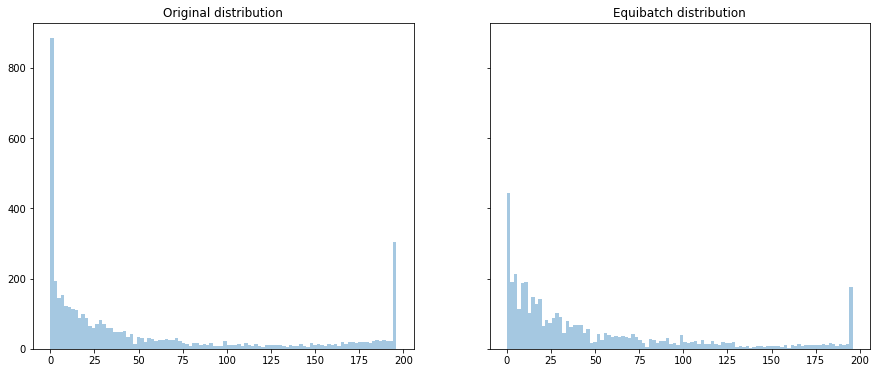

In [24]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches(15, 6)
sns.distplot(np.sum(train_y, axis = (1, 2)), bins = 100, kde = False, ax = ax1)
ax1.set_title('Original distribution')
ax2.set_title('Equibatch distribution')
sns.distplot(np.sum(train_y[batch], axis = (1, 2)),
             bins = 100, kde = False, ax = ax2)

plt.show()

# Example equibatch

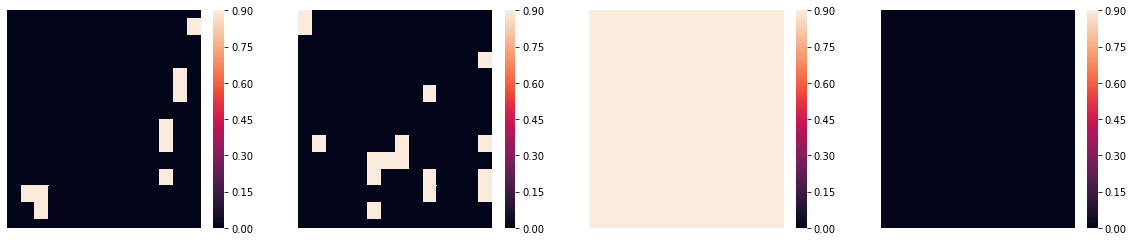

In [25]:
multiplot([x.reshape((14, 14)) for x in train_y[batch[4:8]]])

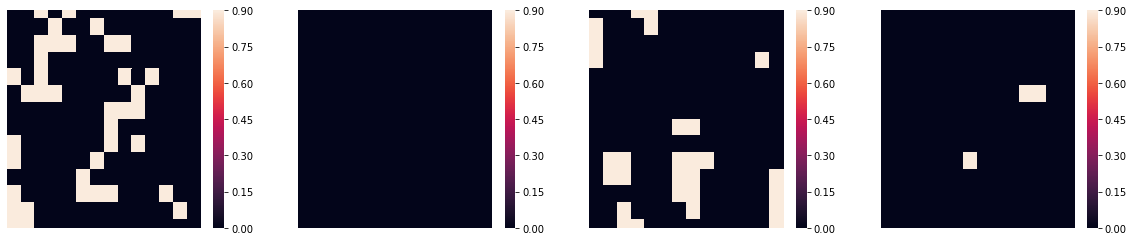

In [26]:
multiplot([x.reshape((14, 14)) for x in train_y[batch[8:12]]])

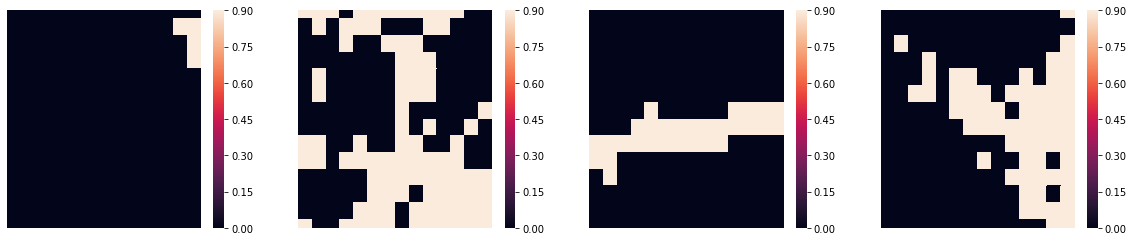

In [27]:
multiplot([x.reshape((14, 14)) for x in train_y[batch[0:4]]])

## Weight cross entropy by effective number of samples

In [28]:
sum_pos = np.sum(train_y[batch])
sum_neg = len(train_y[batch]) * 196 - sum_pos
beta = (sum_pos + sum_neg - 1) / (sum_pos + sum_neg)
print("Beta: {}".format(beta))
samples_per_cls = np.array([sum_neg, sum_pos])
effective_num = 1.0 - np.power(beta, samples_per_cls)
print(effective_num)
weights = (1.0 - beta) / np.array(effective_num)
weights = weights / np.sum(weights)
print("Neg and pos weights: {}".format(weights))
weight = weights[1] / weights[0]
print(weight)


Beta: 0.9999988189720332
[0.52680727 0.22255943]
Neg and pos weights: [0.29699669 0.70300331]
2.3670409476880234


In [29]:
print("Baseline: The positive is: {}".format(weights[0]))
print("Baseline: The negative is: {}".format(weights[1]))
print("\n")
print("Balanced: The positive is: {}".format(weight*weights[0]))
print("Balanced: The negative is: {}".format(weights[1]))


Baseline: The positive is: 0.2969966850823865
Baseline: The negative is: 0.7030033149176136


Balanced: The positive is: 0.7030033149176137
Balanced: The negative is: 0.7030033149176136



# Loss definition

The current best loss is a combination of weighted binary cross entropy and per-image Lovasz-Softmax, with a loss schedule with the latter becoming more important each epoch

In [30]:
from keras.losses import binary_crossentropy
import math
from scipy.ndimage import distance_transform_edt as distance

def weighted_bce_loss(y_true, y_pred, weight, mask = None, smooth = 0.025):
    '''Calculates the weighted binary cross entropy loss between y_true and
       y_pred with optional masking and smoothing for regularization
    
         Parameters:
          y_true (arr):
          y_pred (arr):
          weight (float):
          mask (arr):
          smooth (float):

         Returns:
          loss (float):
    '''
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    y_true = K.clip(y_true, smooth, 1. - smooth)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = tf.nn.weighted_cross_entropy_with_logits(
        y_true,
        logit_y_pred,
        weight,
    )
    return tf.reduce_mean(loss)

def calc_dist_map(seg):
    '''Utility function for calc_dist_map_batch that calculates the loss
       importance per pixel based on the surface distance function
    
         Parameters:
          seg (arr):
          
         Returns:
          res (arr):
    '''
    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)
    loss_importance = np.array([x for x in range(0, 197, 1)])
    loss_importance = loss_importance / 196
    loss_importance = np.expm1(loss_importance)
    loss_importance[:30] = 0.

    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask
        sums = int(np.sum(seg))
        # When % = 1, 0 -> 1.75
        # When % = 100, 0 -> 0
        res[np.where(res == 0)] = -1 * loss_importance[196 - sums]
        # When % = 1, 1 -> 0
        # When % = 100, 1 -> 1.75
        res[np.where(res == 1)] = loss_importance[sums]
        res[np.where(np.isclose(res, 1.41421356, rtol = 1e-2))] = loss_importance[sums]
        
    res[np.where(res < -2)] = -2
    res[np.where(res > 3)] = 3
    if np.sum(seg) == 196:
        res = np.ones_like(seg)
        res *= -1
    if np.sum(seg) == 0:
        res = np.ones_like(seg)
    return res# / max_value

def calc_dist_map_batch(y_true):
    '''Applies calc_dist_map to each sample in an input batch
    
         Parameters:
          y_true (arr):
          
         Returns:
          loss (arr):
    '''
    y_true_numpy = y_true.numpy()
    return np.array([calc_dist_map(y)
                     for y in y_true_numpy]).astype(np.float32)

def surface_loss(y_true, y_pred):
    '''Calculates the mean surface loss for the input batch
       by multiplying the distance map by y_pred
    
         Parameters:
          y_true (arr):
          y_pred (arr):
          
         Returns:
          loss (arr):
        
         References:
          https://arxiv.org/abs/1812.07032
    '''
    y_true_dist_map = tf.py_function(func=calc_dist_map_batch,
                                     inp=[y_true],
                                     Tout=tf.float32)
    multipled = y_pred * y_true_dist_map
    loss = K.mean(multipled)
    return loss

def surf_lovasz(y_true, y_pred, alpha):
    '''Calculates the weighted combination of surface loss and lovasz softmax
    
         Parameters:
          y_true (arr):
          y_pred (arr):
          alpha (float):
          
         Returns:
          loss (arr):
    '''
    lv = lovasz_softmax(y_pred, tf.reshape(y_true, (-1, 14, 14)), classes=[1], per_image=True)
    surf = surface_loss(y_true, y_pred)
    return ( (1-alpha)*lv + (alpha * surf) )
    
def bce_surf(y_true, y_pred, alpha, smooth = 0.075, weight = weight, mask = None, ):
    '''Calculates the weighted combination of binary cross entropy and surface loss
    
         Parameters:
          y_true (arr):
          y_pred (arr):
          alpha (float):
          smooth (float):
          weight (float):
          mask (arr):
          
         Returns:
          loss (arr):
    '''
    bce =  weighted_bce_loss(y_true, y_pred, weight, smooth = smooth)
    surf = surface_loss(y_true, y_pred)
    return ( (1-alpha)*bce + (alpha * surf) )#global_loss #+ regional_loss

def bce_lv(y_true, y_pred, alpha, smooth = 0.075, weight = weight, mask = None, ):
    '''Calculates the weighted combination of binary cross entropy and lovasz softmax
    
         Parameters:
          y_true (arr):
          y_pred (arr):
          alpha (float):
          smooth (float):
          weight (float):
          mask (arr):
          
         Returns:
          loss (arr):
    '''
    bce =  weighted_bce_loss(y_true, y_pred, weight, smooth = smooth)
    lv = lovasz_softmax(y_pred, tf.reshape(y_true, (-1, 14, 14)), classes=[1], per_image=True)
    return ( (1-alpha)*bce + (alpha * lv) )#global_loss #+ regional_loss

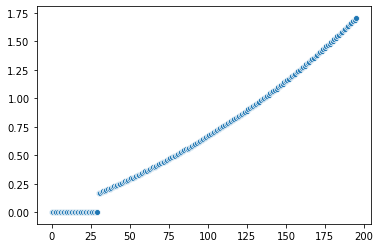

In [31]:
loss_importance = np.array([x for x in range(0, 196, 1)])
loss_importance = loss_importance / 196
loss_importance = np.expm1(loss_importance)
loss_importance[:30] = 0.
sns.scatterplot(y = loss_importance, x = [x for x in range(0, 196)])

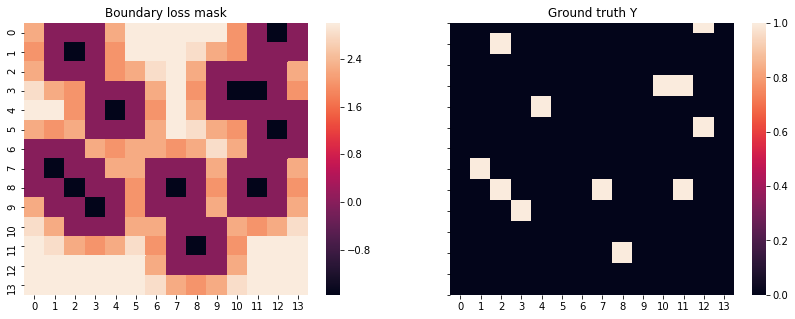

In [32]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches(14, 5)
sns.heatmap(calc_dist_map(test_y[85]), ax = ax1)
ax2.set_title('Ground truth Y')
ax1.set_title('Boundary loss mask')
sns.heatmap(test_y[85], ax = ax2)
plt.show()

# Evaluation metrics

In [33]:
countries = {'africaeast-test': [0, 34],
 'africawest-test': [35, 96],
 'cameroon-test': [97, 135],
 'ethiopia-test': [136, 248],
 'ghana-test': [249, 282],
 'ghana-test-large': [283, 318],
 'global-test': [319, 460],
 'india-test': [461, 511],
 'kenya-test': [512, 600],
 'lac-north-test': [601, 641],
 'lac-south-test': [642, 683], 'all': [0, 683]}

def dice_loss(y_true, y_pred):
    '''Calculates the dice score of ground truth and prediction arrays
    
         Parameters:
          y_true (arr):
          y_pred (arr):
          
         Returns:
          metric (arr):
    '''
    numerator = 2 * np.sum(y_true * y_pred, axis=-1)
    denominator = np.sum(y_true + y_pred, axis=-1)
    return (numerator + 1) / (denominator + 1)

def calc_mean_surface_distance(true, pred):
    '''Calculates the mean surface distance between ground truth
       and prediction arrays
    
         Parameters:
          y_true (arr):
          y_pred (arr):
          
         Returns:
          metric (arr):
    '''
    if np.sum(true) + np.sum(pred) == 0:
        return 0
    if np.sum(true) > 0:
        if np.sum(pred) > 0:
            return assd(pred, true) / 14
        else:
            return 1
    if np.sum(true) == 0:
        if np.sum(pred) > 0:
            return 1

def calculate_metrics(country, al = 0.4):
    '''Calculates the following metrics for an input country, based on
       indexing of the country dictionary:
       
         - Loss
         - F1
         - Precision
         - Recall
         - Dice
         - Mean surface distance
         - Average error
    
         Parameters:
          country (str):
          al (float):
          
         Returns:
          val_loss (float):
          best_dice (float):
          error (float):
    '''
    start_idx = countries[country][0]
    stop_idx = countries[country][1]
    best_f1 = 0
    best_dice = 0
    best_thresh = 0
    hausdorff = 0
    p = 0
    r = 0
    error = 0
    d = 0
    ys = []
    vls = []
    t_alls = []
    test_ids = [x for x in range(len(test_x))]
    for test_sample in test_ids[start_idx:stop_idx]:
        y, vl = sess.run([fm, test_loss], feed_dict={inp: test_x[test_sample].reshape(1, 24, 16, 16, n_bands),
                                          length: test_lengths[test_sample].reshape(1, 1),
                                          is_training: False,
                                          clipping_params['rmax']: rmax_epoch,
                                          clipping_params['rmin']: rmin_epoch,
                                          clipping_params['dmax']: dmax_epoch,
                                          labels: test_y[test_sample, :, :].reshape(1, 14, 14),
                                          alpha: al,
                                          })
        ys.append(y.reshape((14, 14)))
        vls.append(vl)
        t = test_y[test_sample].reshape((14, 14))
        t_alls.append(t)
    to_remove = np.argwhere(vls > np.percentile(vls, 97.5))
    if len(to_remove) >= 0:
        ys = list(np.delete(np.array(ys), to_remove, 0))
        t_alls = list(np.delete(np.array(t_alls), to_remove, 0))
    for thresh in range(7, 13):
        all_preds = []
        all_trues = []
        tps, fps, fns = [], [], []
        abs_error = []
        haus = []
        trues = []
        preds = []
        dice_losses = []
        val_loss = []
        for sample in range(len(ys)):
            pred = np.copy(ys[sample])
            true = t_alls[sample]
            vl = vls[sample]
            haus.append(calc_mean_surface_distance(true, pred))
            #haus.append(scipy.spatial.distance.directed_hausdorff(pred, true)[0])
            pred[np.where(pred > thresh*0.05)] = 1
            pred[np.where(pred < thresh*0.05)] = 0
            true_s = np.sum(true[1:-1])
            pred_s = np.sum(pred[1:-1])
            abs_error.append(abs(pred_s - true_s))
            p_error = np.around(((abs(pred_s - true_s))/196), 3)
            tp, fp, fn = thirty_meter(true, pred)
            tps.append(tp)
            fps.append(fp)
            fns.append(fn)
            trues.append(true_s)
            preds.append(pred_s)
            all_trues.append(true.flatten())
            all_preds.append(pred.flatten())
            if np.sum(true + pred) > 0:
                dice_losses.append(dice_loss(np.array(true).flatten(), np.array(pred).flatten()))
            if np.sum(true + pred) == 0:
                dice_losses.append(1.)
            val_loss.append(np.mean(vl))
        oa_error = np.mean(abs_error)
        precision = np.sum(tps) / (np.sum(tps) + np.sum(fps))
        recall = np.sum(tps) / (np.sum(tps) + np.sum(fns))
        f1 = 2*((precision* recall) / (precision + recall))
        haus = np.mean(haus)
        dices = np.mean(dice_losses)
        if f1 > best_f1:
            best_dice = dices
            best_f1 = f1
            p = precision
            r = recall
            error = oa_error
            to_save_trues = all_trues
            to_save_preds = all_preds
            best_thresh = thresh*0.05
    print("{}: Val loss: {} Thresh: {} F1: {}"
          " R: {} P: {} D: {} H: {} Error: {}".format(country, 
                                                     np.around(np.mean(val_loss), 3),
                                                     np.around(best_thresh, 2),
                                                     np.around(best_f1, 3), np.around(p, 3), np.around(r, 3), 
                                                     np.around(best_dice, 3), np.around(haus, 3),
                                                     np.around(error, 3)))
    return np.mean(val_loss), best_dice, error

# Graph set up

In [34]:
def augment_batch(batch_ids, batch_size):
    '''Performs random flips and rotations of the X and Y
       data for a total of 4 x augmentation
    
         Parameters:
          batch_ids (list):
          batch_size (int):
          
         Returns:
          x_batch (arr):
          y_batch (arr):
    '''
    x = train_x[batch_ids, :, :, :]
    y = train_y[batch_ids, :, :]
    x_batch = np.zeros_like(x)
    y_batch = np.zeros_like(y)
    flips = np.random.choice(np.array([0, 1, 2, 3]), batch_size, replace = True)
    for i in range(x.shape[0]):
        current_flip = flips[i]
        if current_flip == 0:
            x_batch[i, :, :, :] = x[i]
            y_batch[i, :, :] = y[i]
        if current_flip == 1:
            x_batch[i, :, :, :] = np.flip(x[i], 1)
            y_batch[i, :, :] = np.flip(y[i], 0)
        if current_flip == 2:
            x_batch[i, :, :, :] = np.flip(x[i], [2, 1])
            y_batch[i, :, :] = np.flip(y[i], [1, 0])
        if current_flip == 3:
            x_batch[i, :, :, :] = np.flip(x[i], 2)
            y_batch[i, :, :] = np.flip(y[i], 1)

    y_batch = y_batch.reshape((batch_size, 14, 14))
    return x_batch, y_batch

x_batch_test, y_batch_test = augment_batch([0, 1], 2)


In [35]:
FRESH_START = True
best_val = 0.2

START_EPOCH = 1
END_EPOCH = 150
LEARNING_RATE = 3e-3
test_ids = [x for x in range(0, len(test_x))]

print("Starting model with: \n {} zone out \n {} l2 \n {} initial LR \n {} final LR \n {} parameters"
     .format(ZONE_OUT_PROB, L2_REG, INITIAL_LR, FINAL_LR, total_parameters))

if not FRESH_START:
    print("Resuming training with a best validation score of {}".format(best_val))
    
if FRESH_START:
    print("Restarting training from scratch on {} "
          "train and {} test samples, total {}".format(len(train_ids), len(test_ids), len(train_ids)/4))

    # current best 1e-4 5e-3
    optimizer = AdaBoundOptimizer(1e-4, 2e-2)
    train_loss = bce_surf(tf.reshape(labels, (-1, 14, 14, 1)), fm, alpha = alpha)
    #l2_loss = tf.losses.get_regularization_l05oss()
    #train_loss += l2_loss

    ft_optimizer = tf.train.GradientDescentOptimizer(ft_lr)
    
    test_loss = bce_surf(tf.reshape(labels, (-1, 14, 14, 1)), fm, alpha = alpha)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        train_op = optimizer.minimize(train_loss)   
        ft_op = ft_optimizer.minimize(train_loss)
        
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    saver = tf.train.Saver(max_to_keep = 75)
    
print("The graph has been finalized")

The model does not overfit after 100 epochs from 5e-4 to 1e-1
We still need to figure out whether or not to use lovasz for finetune
Starting model with: 
 0.2 zone out 
 0.0 l2 
 0.0001 initial LR 
 0.02 final LR 
 209387 parameters
Restarting training from scratch on 4326 train and 685 test samples, total 1081.5
The graph has been finalized


In [97]:
# This cell should be run to do fine-tuning, if commented - train from scratch
# The master model right now is "../models/march-31-2e2/75-67-2/"
# The finetune 75 alpha model is "../models/april-1-finetune/alpha-75/84-67-6/"
# The finetune 50 alpha model is "../models/april-1-finetune/alpha-50/91-67-8/"
# The finetune 90 alpha model is not good. Alpha should be less than 0.9
path = "../models/april-2-relu-clipped-batrenorm/56-67-9/"
new_saver = tf.train.import_meta_graph(path + 'model.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(path))

INFO:tensorflow:Restoring parameters from ../models/april-2-relu-clipped-batrenorm/56-67-9/model


In [36]:
train_losses = []
test_losses = []
dices = []
errors = []

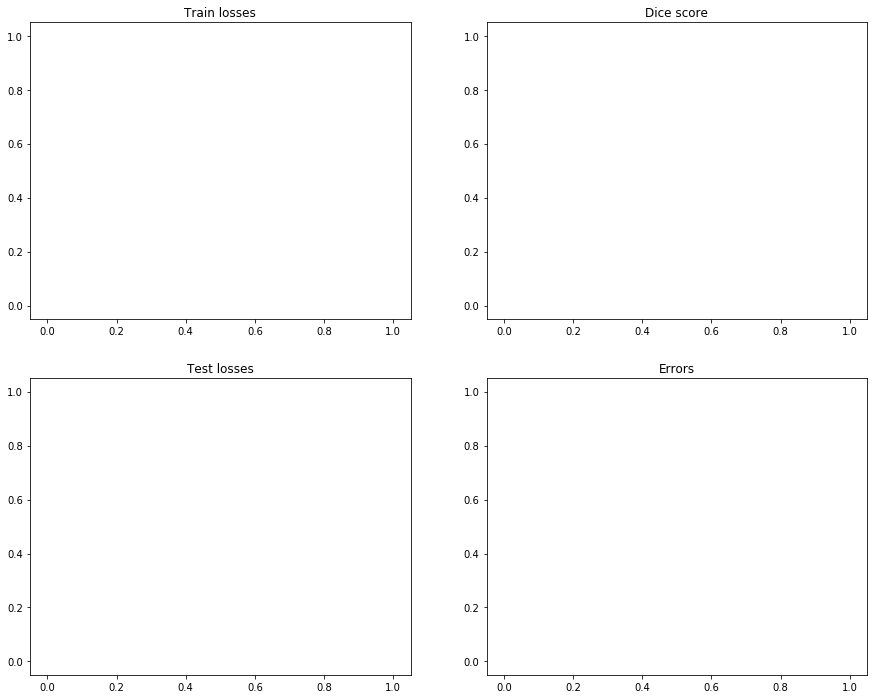

In [37]:
f, ((c1r1, c1r2), (c2r1, c2r2)) = plt.subplots(2, 2, sharey=False)
f.set_size_inches(15, 12)

c1r1.set_title("Train losses")
sns.scatterplot(y = np.array(train_losses[:]),
                x = np.array([x for x in range(len(train_losses[:]))]),
               ax = c1r1)

c1r2.set_title("Dice score")
sns.scatterplot(y = np.array(dices[:]),
                x = np.array([x for x in range(len(dices[:]))]),
               ax = c1r2)

c2r1.set_title("Test losses")
sns.scatterplot(y = np.array(test_losses[:]),
                x = np.array([x for x in range(len(test_losses[:]))]),
               ax = c2r1)

c2r2.set_title("Errors")
sns.scatterplot(y = np.array(errors[:]),
                x = np.array([x for x in range(len(errors[:]))]),
               ax = c2r2)

plt.show()

In [38]:
# Make sure that the equibatch is working with the augmentation
randomize = equibatch(train_ids)
sum_no_equibatch = []
sum_equibatch = []
for k in tnrange(int(len(randomize) // 20)):
    rand = [x for x in range(len(randomize))]
    batch_ids = rand[k*BATCH_SIZE:(k+1)*BATCH_SIZE]
    _, y_batch = augment_batch(batch_ids, BATCH_SIZE)
    sum_no_equibatch.append(np.sum(y_batch))
    
for k in tnrange(int(len(randomize) // 20)):
    batch_ids = randomize[k*BATCH_SIZE:(k+1)*BATCH_SIZE]
    _, y_batch = augment_batch(batch_ids, BATCH_SIZE)
    sum_equibatch.append(np.sum(y_batch))
    
print("No equibatch SD: {}".format(np.std(np.array(sum_no_equibatch))))
print("Equibatch SD: {}".format(np.std(np.array(sum_equibatch))))

[979, 323, 301, 340, 382, 356, 341, 295, 786]



No equibatch SD: 516.447386242146
Equibatch SD: 114.89874433873193


In [ ]:
import scipy
best_val = 0.5
fine_tune = False
countries['all'] = [0, len(test_x)]
ft_epochs = 0
ft_learning_rate = 1e-2

# 86, 0.846 F1, 676 D, 10.82 Error
train_ids = [x for x in range(len(train_y))]
for i in range(2, 77+75):
    al = np.min( [(0.01 + (0.01 * i)), 0.67] )
    #al = 0.7
    if al < 0.67:
        test_al = 0.25
    else:
        test_al = al
    if fine_tune == True:
        op = ft_op
        ft_epochs += 1
        if ft_epochs % 15 == 0:
            ft_learning_rate /= 2
        print("FINE TUNING WITH {} LR".format(ft_learning_rate))
        
    else:
        op = op = train_op
    randomize = equibatch(train_ids)
    print("starting epoch {}, alpha: {}, drop: {}".format(i, al, np.max((1. - (i*0.003), 0.75))))
    
    loss = train_loss
    BATCH_SIZE = 20
    test_ids = [x for x in range(0, len(test_x))]
    losses = []
    
    for k in tnrange(int(len(randomize) // BATCH_SIZE)):
        rmax_epoch, dmax_epoch, rmin_epoch = calc_renorm_params(i, len(train_y), 20, k)
        if k % 10 == 0:
            sleep(2)
        batch_ids = randomize[k*BATCH_SIZE:(k+1)*BATCH_SIZE]
        x_batch, y_batch = augment_batch(batch_ids, BATCH_SIZE)
        opt, tr = sess.run([op, loss],
                          feed_dict={inp: x_batch,
                                     length: train_l[batch_ids].reshape((-1, 1)),
                                     labels: y_batch,
                                     is_training: True,
                                     clipping_params['rmax']: rmax_epoch,
                                     clipping_params['rmin']: rmin_epoch,
                                     clipping_params['dmax']: dmax_epoch,
                                     keep_rate: np.max((1. - (i*0.003), 0.8)),
                                     alpha: al,
                                     ft_lr: ft_learning_rate,
                                     })
        losses.append(tr)
    
    print("Epoch {}: Loss {}".format(i, np.around(np.mean(losses[:-1]), 3)))
    #_, _, _, _ = calculate_metrics("global-test", al = al)
    val_loss, dice, error = calculate_metrics('all', al = test_al)
    train_losses.append(np.mean(losses[:-1]))
    test_losses.append(val_loss)
    dices.append(dice)
    errors.append(error)
    if dice > (best_val - 0.005):
        print("Saving model with {}".format(dice))
        os.mkdir("../models/april-3-upconv/{}-{}-{}/".format(str(i), str(dice*100)[:2], str(dice*100)[3]))
        save_path = saver.save(sess, "../models/april-3-upconv/{}-{}-{}/model".format(str(i), str(dice*100)[:2], str(dice*100)[3]))
        if dice > best_val:
            best_val = dice

[979, 323, 301, 340, 382, 356, 341, 295, 786]
starting epoch 2, alpha: 0.03, drop: 0.994



Epoch 2: Loss 0.8109999895095825
all: Val loss: 0.5809999704360962 Thresh: 0.5 F1: 0.786 R: 0.777 P: 0.796 D: 0.591 H: 0.292 Error: 18.49
Saving model with 0.5912101130840822
[979, 323, 301, 340, 382, 356, 341, 295, 786]
starting epoch 3, alpha: 0.04, drop: 0.991


In [277]:
i = 76
dice = 0.666
os.mkdir("../models/march-31/{}-{}-{}/".format(str(i), str(dice*100)[:2], str(dice*100)[3]))
save_path = saver.save(sess, "../models/march-31/{}-{}-{}/model"
                       .format(str(i), str(dice*100)[:2], str(dice*100)[3]))

In [ ]:
# This is for documentation purposes, leave for now
import scipy
al = 0.6
calculate_metrics('ethiopia', al = al) #0.81 -> 0.818, 0.695 -> 0.711
calculate_metrics('ghana', al = al)
calculate_metrics('kenya', al = al) # 0.798, 0.724 -> 0.806, 0.739
calculate_metrics('lac', al = al) # 0.85, 0.768 -> 0.855, 0.782
calculate_metrics('india', al = al) # 0.76 -> 0.766
calculate_metrics('africaeast', al = al)
calculate_metrics('africawest', al = al)
calculate_metrics('cameroon', al = al)
val_loss, dice = calculate_metrics('all', al = al) # 0.804, 0.639 -> 0.808, 0.645

# Model validation and sanity checks





In [85]:
# rmax, dmax not clipped
countries['all'] = [0, len(test_x)]
_, _, error = calculate_metrics('all')

all: Val loss: 0.42100000381469727 Thresh: 0.55 F1: 0.824R: 0.828 P: 0.819 D: 0.652 H: 0.291 Error: 12.931


In [40]:
start = 350

test_ids = [x for x in range(0, len(test_x))]

def multiplot(matrices, nrows = 2, ncols = 4):
    '''Docstring
    
         Parameters:
          matrices (list):
          nrows (int):
          
         Returns:
          None
    '''
    fig, axs = plt.subplots(ncols=4, nrows = nrows)
    fig.set_size_inches(20, 4*nrows)
    to_iter = [[x for x in range(i, i + ncols + 1)] for i in range(0, nrows*ncols, ncols)]
    for r in range(1, nrows + 1):
        min_i = min(to_iter[r-1])
        max_i = max(to_iter[r-1])
        for i, matrix in enumerate(matrices[min_i:max_i]):
            sns.heatmap(data = matrix, ax = axs[r - 1, i], vmin = 0, vmax = 0.9)
            axs[r - 1, i].set_xlabel("")
            axs[r - 1, i].set_ylabel("")
            axs[r - 1, i].set_yticks([])
            axs[r - 1, i].set_xticks([])
    plt.show



In [41]:
def identify_alignment(true, pred, wsize = 3, difference = 0.2):
    '''Docstring
    
         Parameters:
          true (arr):
          pred (arr):
          wsize (int):
          difference (float):
          
         Returns:
          None
    '''
    n_single_trees = 0
    for x in range(1, true.shape[0] - 1, 1):
        for y in range(1, true.shape[1] - 1, 1):
            wind_true = true[x-1:x+2, y-1:y+2]
            wind_pred = pred[x-1:x+2, y-1:y+2]
            if wind_true[1, 1] == 1:
                if np.sum(wind_true) == 1:
                    n_single_trees += 1
                    pred_place = np.argmax(wind_pred.flatten())
                    diff = wind_pred.flatten()[pred_place] - wind_pred.flatten()[4]
                    if pred_place != 4:
                        if diff > difference:
                            x_lv = pred_place // 3
                            y_lv = pred_place % 3
                            print(x_lv, y_lv)
                            proposed = wind_true[x_lv - 1:x_lv+2, y_lv-1:y_lv+2]
                            if np.sum(proposed) == 0:
                                print("There is a missed position at {} x, {} y: {}".format(x, y, diff))

0.5693430656934306
[390, 391, 392, 393, 394, 395, 396, 397]
0 0
There is a missed position at 9 x, 5 y: 0.21025335788726807


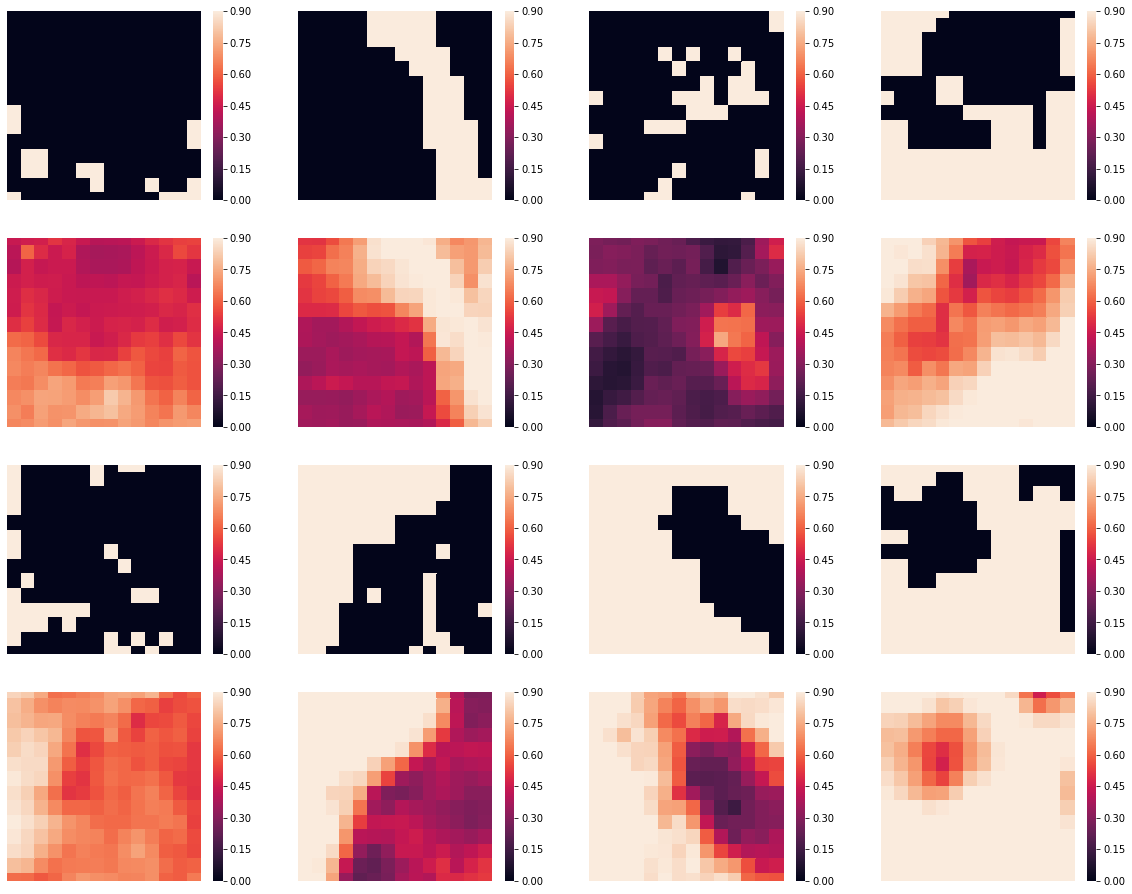

In [47]:
from sklearn.metrics import f1_score
print(start/len(test_ids))
test_ids = sorted(test_ids)
matrix_ids = [test_ids[start], test_ids[start + 1], test_ids[start + 2], test_ids[start + 3],
              test_ids[start + 4], test_ids[start + 5], test_ids[start + 6], test_ids[start + 7]]
preds = []
trues = []
print(matrix_ids)
for i in matrix_ids:
    idx = i
    y = sess.run([fm], feed_dict={inp: test_x[idx].reshape(1, 24, IMAGE_SIZE, IMAGE_SIZE, n_bands),
                                  length: test_lengths[idx].reshape(1, 1),
                                  is_training: False,
                                  clipping_params['rmax']: rmax_epoch,
                                  clipping_params['rmin']: rmin_epoch,
                                  clipping_params['dmax']: dmax_epoch,
                                  })
    y = np.array(y).reshape(14, 14)
    preds.append(y)
    y2 = np.copy(y)
    #y[np.where(y > 0.4)] = 1.0
    #y[np.where(y < 0.4)] = 0.
    #y[np.where(y >= 0.4)] = 1.
    #dc = np.around(dice_loss(test_y[idx].flatten(), y2.flatten()), 3)
    true = test_y[idx].reshape(14, 14)
    #y[np.where(y > 0.4)] = 1.
    identify_alignment(true, y)
    #f1 = f1_score(true.flatten(), y.flatten())
    #print(i, f1, (1-f1)*np.sum(true))
    #if np.sum(true[1:-1]) > 0 and np.sum(y[1:-1]) > 0:
    #    print(i, assd(true[1:-1], y[1:-1]))
    #print(i, np.sum(abs(true - y)))
    trues.append(true)
    
    
""


to_plot = trues[0:4] + preds[0:4] + trues[4:] + preds[4:]

multiplot(to_plot, nrows = 4, ncols = 4)
# 448"109, ""
start = start + 8 
# 50, 64, 66, 83, 94


In [189]:
train_ids = [x for x in range(train_x.shape[0])]
train_ids = sorted(train_ids)
start = 25

6
[25, 26, 27, 28, 29, 30, 31, 32, 33]


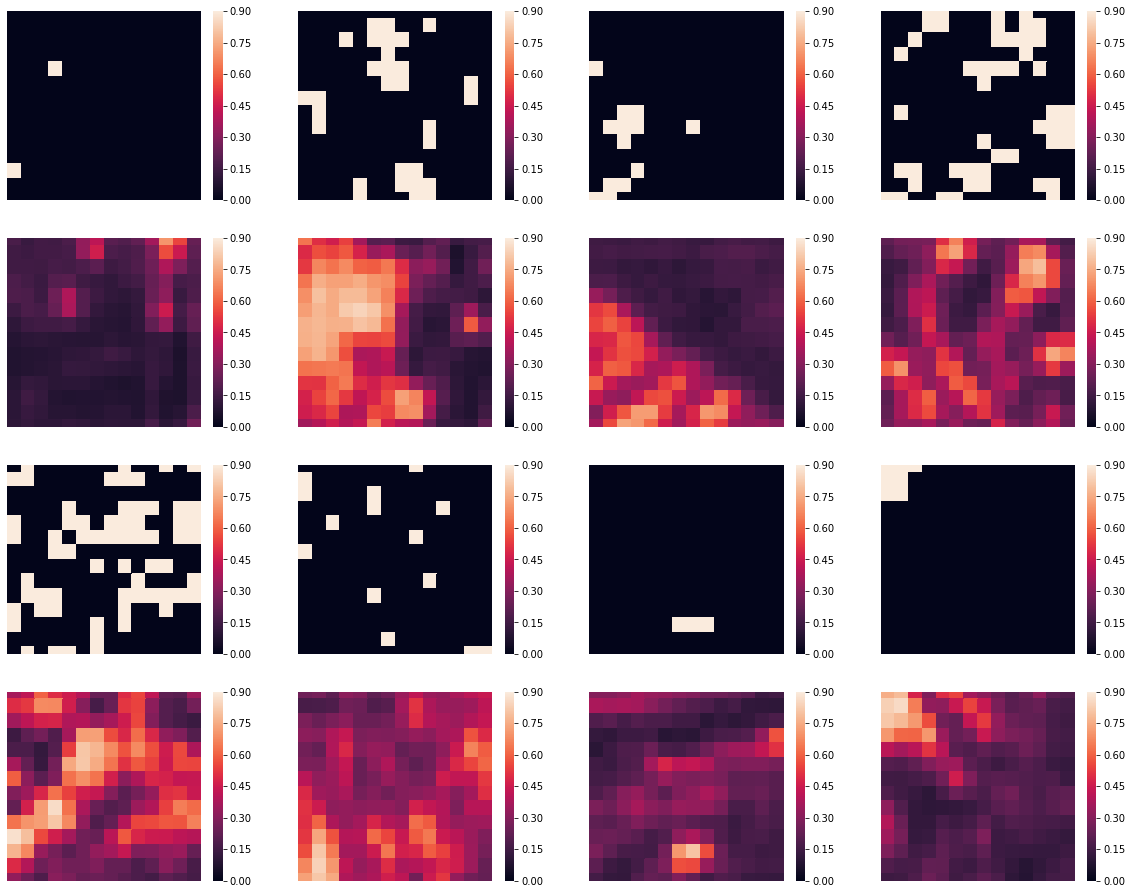

In [190]:
#atrix_ids = random.sample(755, 4)
matrix_ids = [train_ids[start], train_ids[start + 1], train_ids[start + 2], train_ids[start + 3], train_ids[start + 4],
             train_ids[start + 5], train_ids[start + 6], train_ids[start + 7], train_ids[start + 8]]

preds = []
trues = []
print(start//4)
print(matrix_ids)
for i in matrix_ids:
    idx = i
    y = sess.run([fm], feed_dict={inp: train_x[idx].reshape(1, 24, IMAGE_SIZE, IMAGE_SIZE, n_bands),
                                  length: train_l[idx].reshape(1, 1),
                                  is_training: False,
                                  clipping_params['rmax']: rmax_epoch,
                                  clipping_params['rmin']: rmin_epoch,
                                  clipping_params['dmax']: dmax_epoch,
                                  })
    y = np.array(y).reshape(14, 14)
    #y[np.where(y > 0.3)] = 0.85
    preds.append(y)
    true = train_y[idx].reshape(14, 14)
    #identify_alignment(true, y)
    trues.append(true)
    
start += 8

to_plot = trues[0:4] + preds[0:4] + trues[5:] + preds[5:]
multiplot(to_plot, nrows = 4, ncols = 4)  

## Identify the top 10% of training and testing samples by loss

In [ ]:
tr_ls = []
for i in range(len(test_x)):
    #if i % 4 == 0:
    print(i)
    y, losses = sess.run([fm, train_loss], feed_dict={inp: test_x[i].reshape((1, 24, 16, 16, n_bands)),
                                         length: test_lengths[i].reshape((-1, 1)),
                                         labels: test_y[i].reshape((1, 14, 14)),
                                         is_training: False,
                                         keep_rate: 0.8,
                                         #keep_rate: np.max((0.97 - (i*0.01), 0.85)),
                                         alpha: 0.5,
                                         ft_lr: 0.004,
                                         })
    y = np.array(y).reshape(14, 14)
    y[np.where(y > 0.4)] = 1.0
    y[np.where(y < 0.4)] = 0.
    preds.append(y)
    true = test_y[i].reshape(14, 14)
    print(i, np.sum(y) - np.sum(true))
    identify_alignment(true, y, difference = 0.4)
    tr_ls.append(losses)

In [146]:
to_id = np.argwhere(np.array(tr_ls) > np.percentile(tr_ls, 90))
to_id.flatten()